In [59]:
import cv2
import math
import numpy as np
from matplotlib import pyplot as plt
from scipy.signal import convolve2d

In [60]:
def mostrar_imagen(imagen, titulo=''):
    plt.figure(figsize=(10, 6))
    plt.imshow(cv2.cvtColor(imagen, cv2.COLOR_BGR2RGB))
    plt.title(titulo)
    plt.axis('off')
    plt.show()

In [61]:
def calcular_fm(img):
    height, width = img.shape[:2]
    # Paso 1: calcular transformada de fourier
    f = np.fft.fft2(img)
    # Paso 2: desplazar el origen/cero al centro
    fc = np.fft.fftshift(f)
    # Paso 3: calcular magnitud
    af = np.abs(fc)
    # Paso 4: calculo el maximo de af
    m = np.max(af)
    # Paso 5: calculo el umbral
    umbral = m/1000
    # Paso 6: calculo la cantidad de pixeles mayores al umbral
    th = np.sum(af > umbral)
    #Paso 7: calculo la calidad de la imagen
    fm = th / (height * width)
    return fm

In [62]:
def crop_central_region(img, percent):
    """
    Recorta una región central de la imagen según un porcentaje dado.
    
    Args:
        img (np.ndarray): Imagen en formato NumPy (BGR o gris).
        percent (float): Porcentaje (entre 0 y 100) del área total que querés mantener.

    Returns:
        np.ndarray: Recorte central de la imagen.
    """
    if percent <= 0 or percent > 100:
        raise ValueError("percent debe estar entre 0 y 100.")

    h, w = img.shape[:2]
    scale = (percent / 100) ** 0.5  # Escalado sobre alto y ancho (por área)

    crop_h = int(h * scale)
    crop_w = int(w * scale)

    start_y = (h - crop_h) // 2
    start_x = (w - crop_w) // 2

    return img[start_y:start_y + crop_h, start_x:start_x + crop_w]

In [63]:
def variance_of_laplacian(img):
    """
    Calcula la varianza del Laplaciano de una imagen en escala de grises.

    Args:
        img_gray (np.ndarray): Imagen 2D en escala de grises (uint8 o float).

    Returns:
        float: Varianza del Laplaciano.
    """
    frame_gris = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Filtro Laplaciano clásico 3x3
    laplacian_kernel = np.array([[0,  1, 0],
                                 [1, -4, 1],
                                 [0,  1, 0]])

    # Aplicar convolución (borde='symm' para manejar bordes bien)
    laplacian = convolve2d(frame_gris, laplacian_kernel, mode='same', boundary='symm')

    # Calcular varianza del resultado
    return np.var(laplacian)

In [64]:


def dividir_en_subsecciones(frame, n_rows, n_cols, stride_in_px=16, show_rectagle=False, color=(0, 255, 0), thickness=1):
    """
    Divide un frame en n_rows × n_cols regiones.

    Args:
        frame (np.ndarray): imagen BGR de entrada.
        n_rows (int): cantidad de filas.
        n_cols (int): cantidad de columnas.

    Returns:
        List[np.ndarray]: lista de sub-imágenes (regiones).
    """
    height, width, _ = frame.shape
    region_height = height // n_rows
    region_width = width // n_cols
    half_stride = math.ceil(stride_in_px / 2)

    new_frame = frame.copy()

    regiones = []
    margenes = []

    for i in range(n_rows):
        for j in range(n_cols):
            if j < n_cols// 3 or j > (2 * n_cols // 3) or i < n_rows // 4 or i > (3 * n_rows // 4):
                continue
            y_start = i * region_height + half_stride
            y_end = (i + 1) * region_height - half_stride
            x_start = j * region_width + half_stride
            x_end = (j + 1) * region_width - half_stride

            margenes.append(((x_start, y_start),( x_end, y_end)))

            region = frame[y_start:y_end, x_start:x_end]
            regiones.append(region)

    if show_rectagle:
        for r in margenes:
            top_left = r[0]
            bottom_right = r[1]
            cv2.rectangle(new_frame, top_left, bottom_right, color, thickness)
        mostrar_imagen(new_frame, titulo='Subsecciones con rectángulos')

    return regiones

In [65]:
def calcular_fm_promedio_subsecciones(frame, n_rows, n_cols, show_rectagle=False):
    sub_secciones = dividir_en_subsecciones(frame, n_rows, n_cols, show_rectagle=show_rectagle)
    formulas = [calcular_fm(sub_seccion) for sub_seccion in sub_secciones]
    fm_promedio = np.mean(formulas)
    return fm_promedio

In [66]:
def calcular_laplacian_promedio_subsecciones(frame, n_rows, n_cols, show_rectagle=False):
    sub_secciones = dividir_en_subsecciones(frame, n_rows, n_cols, show_rectagle=show_rectagle)
    formulas = [variance_of_laplacian(sub_seccion) for sub_seccion in sub_secciones]
    fm_promedio = np.mean(formulas)
    return fm_promedio

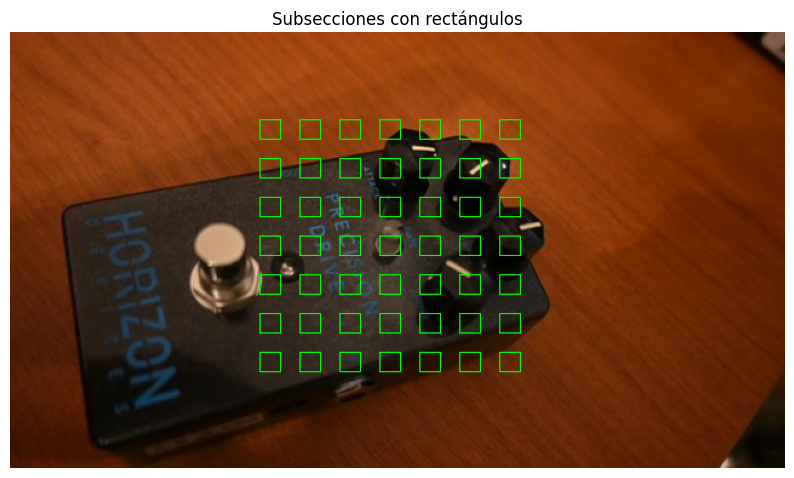

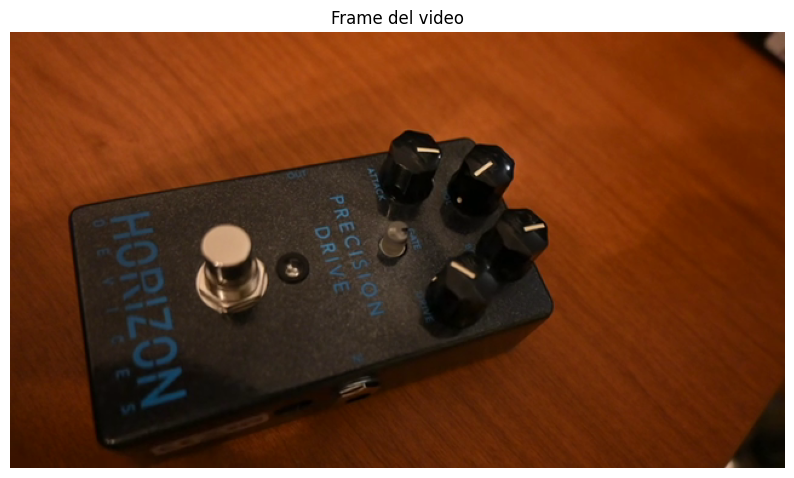

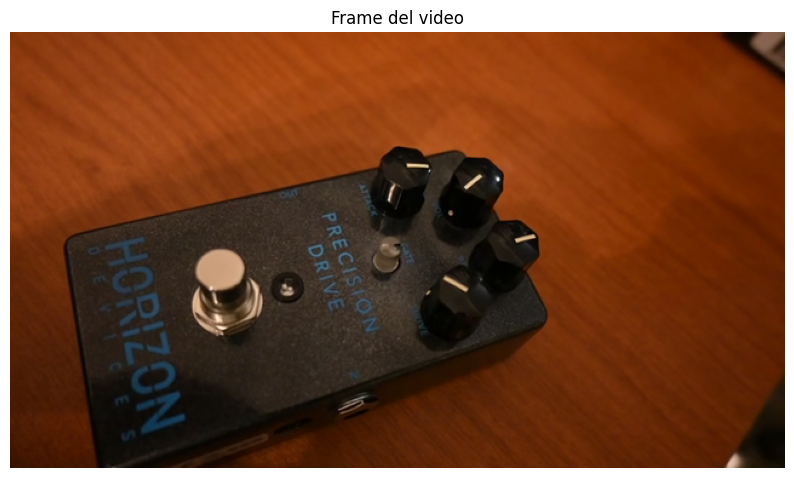

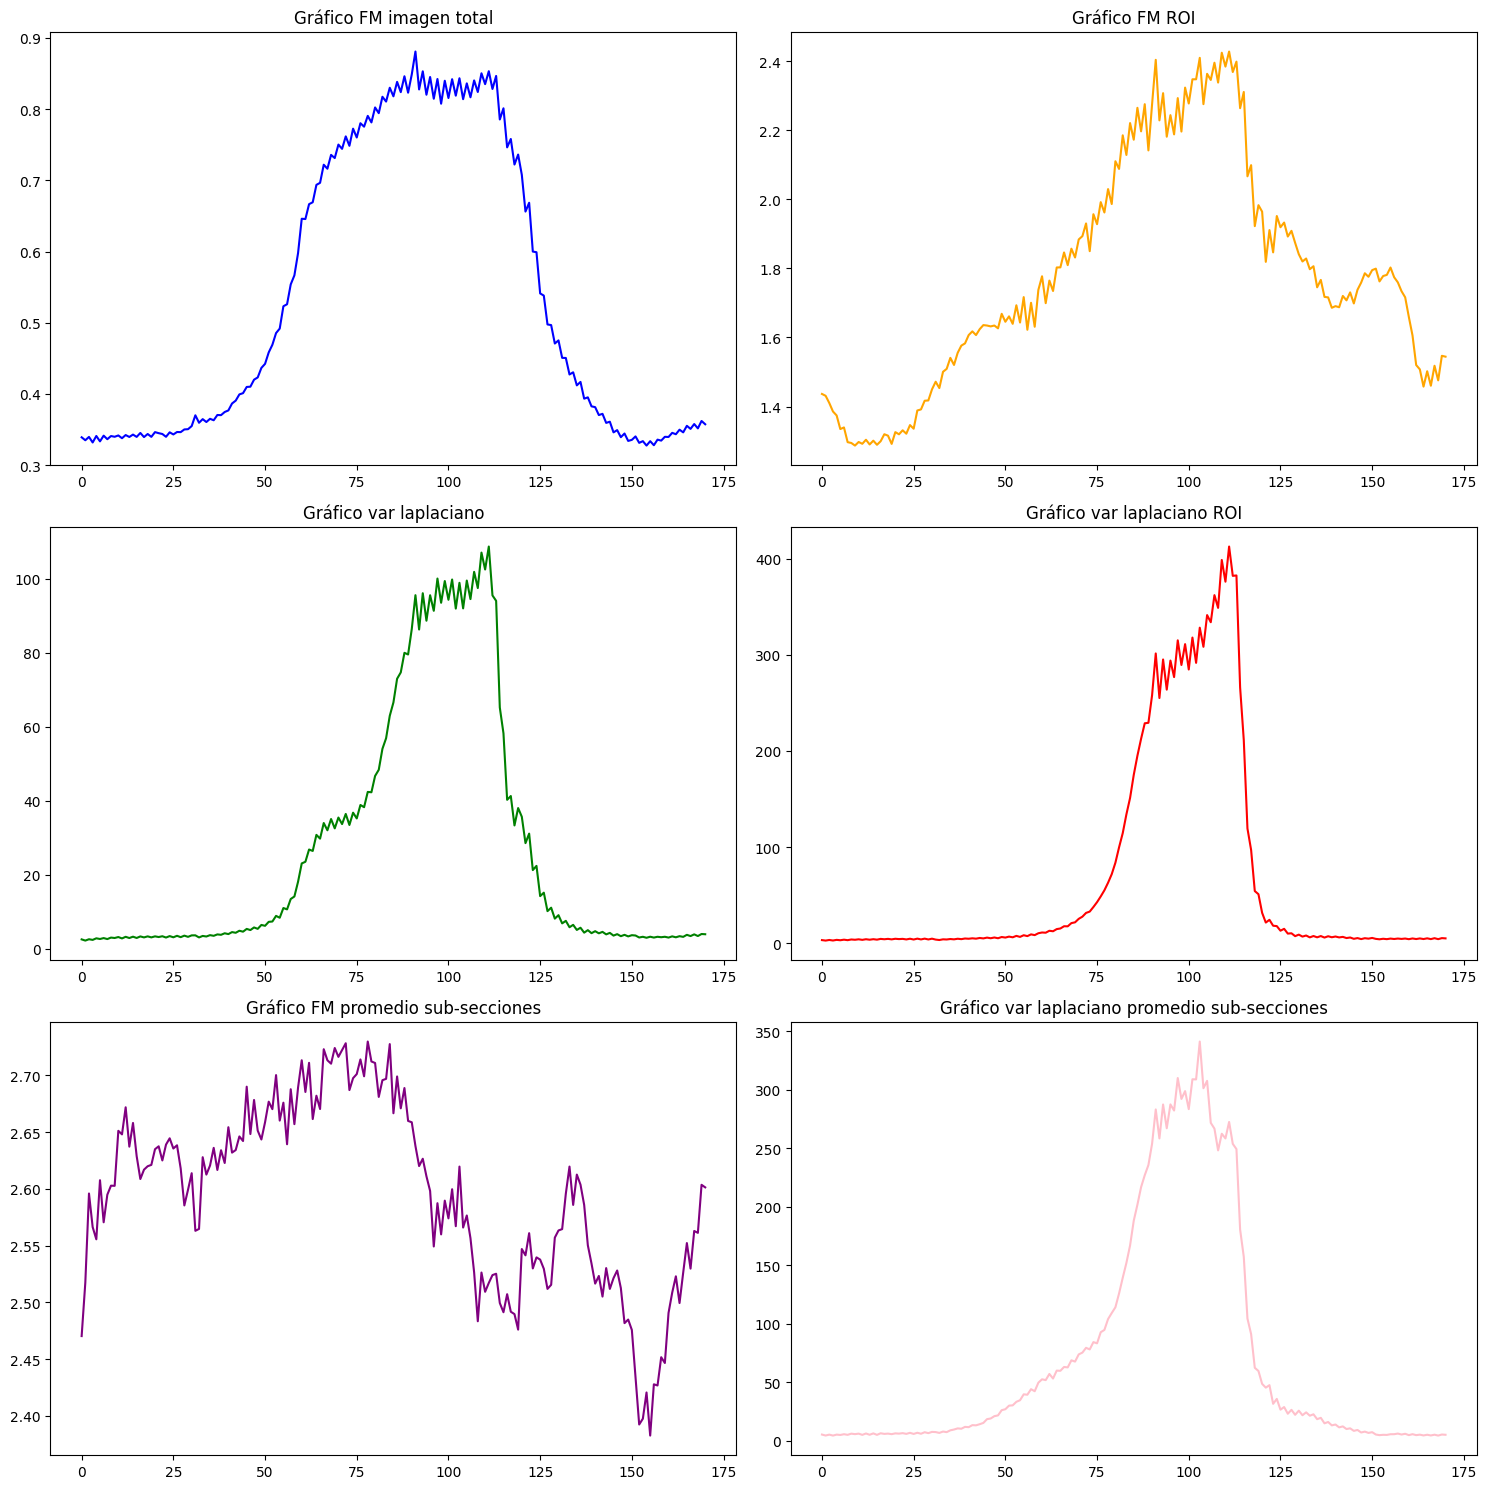

In [71]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Nuevas dimensiones (mitad del tamaño original)
    half_width = frame_width // 20
    half_height = frame_height // 20
    # Coordenadas de inicio
    start_y = frame_height // 40    
    start_x = frame_width // 40
    
    fm_total_list = []
    fm_roi_list = []
    var_laplacian_list = []
    var_laplacian_roi_list = []

    N = 11
    M = 19

    fm_mean = []
    laplacian_mean = []

    while True:
        ret, frame = captura_video.read()
        if not ret:
            break

        # Calculo el fm del total de la imagen
        fm_total_list.append(calcular_fm(frame))

        # Recorte central
        central_crop = crop_central_region(frame, 10)
        #Calculo el fm del roi
        fm_roi_list.append(calcular_fm(central_crop))

        # calcula la varianza del laplaciano
        var_laplacian_list.append(variance_of_laplacian(frame))

        # calcula la varianza del laplaciano para el ROI
        var_laplacian_roi_list.append(variance_of_laplacian(central_crop))

        # Calculo el fm y el laplacian promedio de las sub-secciones
        fm_mean.append(calcular_fm_promedio_subsecciones(frame, N, M, len(fm_total_list) in [84]))
        laplacian_mean.append(calcular_laplacian_promedio_subsecciones(frame, N, M))

        if len(fm_total_list) in [91, 111]:
            mostrar_imagen(frame, titulo='Frame del video')

    fig, axes = plt.subplots(3, 2, figsize=(15, 15))

    axes[0][0].plot(fm_total_list, color='blue')
    axes[0][0].set_title("Gráfico FM imagen total")

    axes[0][1].plot(fm_roi_list, color='orange')
    axes[0][1].set_title("Gráfico FM ROI")


    axes[1][0].plot(var_laplacian_list, color='green')
    axes[1][0].set_title("Gráfico var laplaciano")

    axes[1][1].plot(var_laplacian_roi_list, color='red')
    axes[1][1].set_title("Gráfico var laplaciano ROI")

    axes[2][0].plot(fm_mean, color='purple')
    axes[2][0].set_title("Gráfico FM promedio sub-secciones")

    axes[2][1].plot(laplacian_mean, color='pink')
    axes[2][1].set_title("Gráfico var laplaciano promedio sub-secciones")


    plt.tight_layout()
    plt.show()

In [68]:
print(f"El índice del frame con el mayor valor de FM en la imagen total es: {np.argmax(fm_total_list)}")
print(f"El índice del frame con el mayor valor de FM en la ROI es: {np.argmax(fm_roi_list)}")
print(f"El índice del frame con el mayor valor de var laplaciano es: {np.argmax(var_laplacian_list)}")
print(f"El índice del frame con el mayor valor de var laplaciano en la ROI es: {np.argmax(var_laplacian_roi_list)}")
print(f"El índice del frame con el mayor valor promedio de FM en NxM({N}x{M}) es: {np.argmax(fm_mean)}")
print(f"El índice del frame con el mayor valor promedio de laplaciano en NxM({N}x{M}) es: {np.argmax(laplacian_mean)}")

El índice del frame con el mayor valor de FM en la imagen total es: 91
El índice del frame con el mayor valor de FM en la ROI es: 111
El índice del frame con el mayor valor de var laplaciano es: 111
El índice del frame con el mayor valor de var laplaciano en la ROI es: 111
El índice del frame con el mayor valor promedio de FM en NxM(12x19) es: 84
El índice del frame con el mayor valor promedio de laplaciano en NxM(12x19) es: 97


In [69]:
# Abre el video
video_path = 'focus_video.mov'
captura_video = cv2.VideoCapture(video_path)

if not captura_video.isOpened():
    print("Error al abrir el archivo de video")
else:
    # Obtén las dimensiones del video
    frame_width = int(captura_video.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(captura_video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    # Nuevas dimensiones (mitad del tamaño original)
    new_width = frame_width // 2
    new_height = frame_height // 2
    
    # Obtén la tasa de cuadros (frame rate) del video
    fps = int(captura_video.get(cv2.CAP_PROP_FPS))
    #fps = 35
    delay = int(600 / fps)
    
    while True:
        ret, frame = captura_video.read()
        if not ret:
            break
        
        # Reducir el tamaño del frame
        frame_resized = cv2.resize(frame, (new_width, new_height))
        
        # Aplicar blur gaussiano al frame reducido
        frame_blur = cv2.GaussianBlur(frame_resized, (15, 15), 1.5)
        
        # Combina el frame original y el frame con blur lado a lado
        frame_combined = np.hstack((frame_resized, frame_blur))

        # Mostrar el frame combinado
        cv2.imshow('Video Original y Blur Gaussiano', frame_combined)
        
        # Salir del loop si se presiona la tecla 'q'
        if cv2.waitKey(delay) & 0xFF == ord('q'):
            break

# Libera el objeto de captura de video y cierra todas las ventanas
captura_video.release()
cv2.destroyAllWindows()